# Step 1. 인물모드 직접 해 보기

* 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
* 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
* 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다.

### 세그멘테이션(Segmentation)이 뭔가요?
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 합니다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정합니다. 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.

### 시맨틱 세그멘테이션(semantic segmentation)이란?

세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 합니다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다. 오늘 다룰 세그멘테이션 방법이기도 하죠.

### 인스턴스 세그멘테이션(Instance segmentation)이란?

시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.

더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다.

### 딥러닝에 기반한 방법 이전에는 어떻게 이미지 세그멘테이션을 했을까?

* 워터쉐드 세그멘테이션(watershed segmentation)

이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것입니다. 그럼 경계는 어떻게 나눌 수 있을까요?

이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가집니다. 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있습니다. 낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됩니다.

자세한 내용은 opencv-python tutorial을 참고해 주세요.

## 1.1 시맨틱 세그멘테이션 다뤄보기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(1440, 1440, 3)


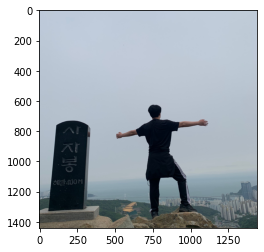

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/등산.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
#PixelLib에서 제공해 주는 모델을 다운로드

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fe6bc7e1340>)

In [11]:
#PixelLib로 사용할 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#모델에 이미지를 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

#Pascal dataset labels
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

#color palette
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
    
colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [12]:
print(colormap[15]) # person

[192 128 128]


In [13]:
# 여기서 주의할 것은 output 이미지가 BGR순서로 채널 배치가 되어 있다는 점이에요.
# colormap은 RGB 순서이고요.
# 그래서 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔줘야 합니다.
seg_color = (128,128,192)

(1440, 1440)


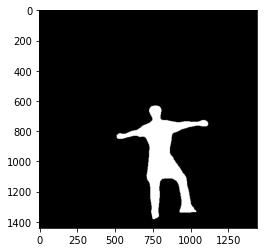

In [14]:
#seg_color로만 이루어진 마스크
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다.
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

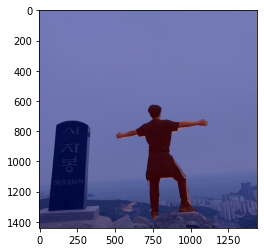

In [15]:
#원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 확인

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 1.2 배경 흐리게 하기

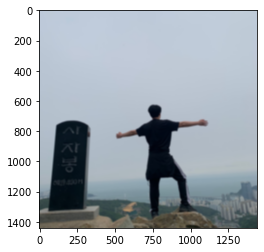

In [19]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

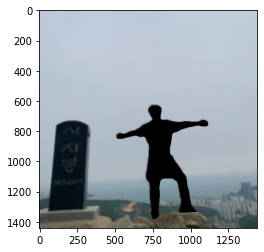

In [22]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 1.3 흐린 배경과 원본 영상 합성

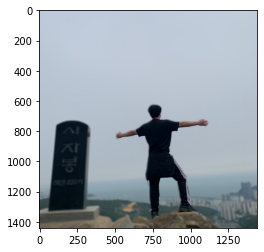

In [23]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 강아지

(1440, 1080, 3)


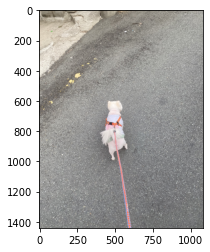

In [43]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/깡이.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

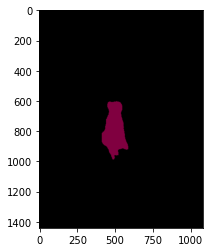

In [44]:
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [46]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [48]:
colormap[12]

array([ 64,   0, 128])

(1440, 1080)


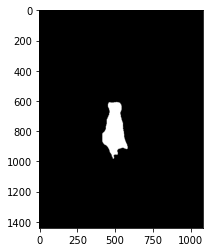

In [49]:
colormap[12]
seg_color = (128,0,64)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

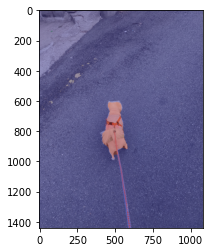

In [50]:
# 원래 이미지와 겹쳐서 보기
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

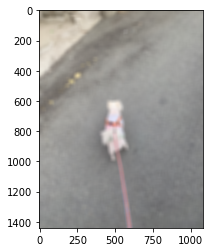

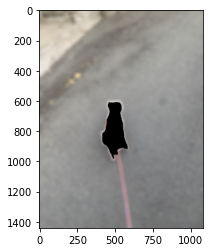

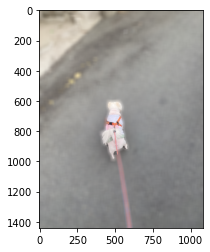

In [52]:
#배경흐리게하기
# (13,13)은 blurring kernel size를 뜻합니다
img_orig_blur = cv2.blur(img_orig, (30,30))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 영상과 사람 영상 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 배경 크로마키

In [53]:
#배경 이미지와 원본 이미지 사이즈 차이를 없애주기 위해 resize 필요함
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/대전.jpg'  
bg_orig = cv2.imread(bg_path)

(387, 349, 3)


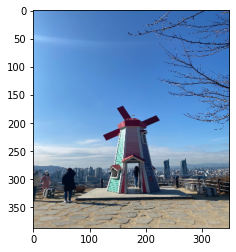

In [54]:
print(img_resize.shape)
plt.imshow(cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB))
plt.show()

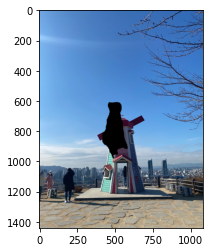

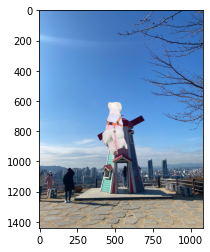

In [55]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_concat = cv2.bitwise_and(bg_orig, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_concat, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_concat)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기

강아지 사진을 blur 했을 때 자세히 보니 강아지까지 blur 된거같아 보이는 문제점이 있었습니다. 

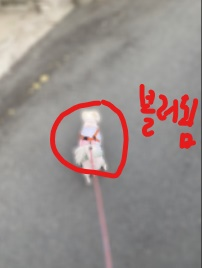

## Step 3. 해결 방법을 제안해 보기

Struct2Depth : 픽셀 단위의 RGB 정보 뿐 아니라 깊이 관계까지 예측하는 방법

* 좀더 정확한 세그멘테이션을 위해 사진 속 RGB 입력으로부터 깊이를 예측한 Struct2Depth를 사용하여 background와 피사체 간의 깊이를 파악하면 좀더 원하는 결과가 나올 수 있다고 한다.

## 회고

피사체가 작거나 색상이 비슷하거나 여러 피사체가 있다면 정확한 세그멘테이션이 힘들고 그에 대한 방안을 Struct2Depth을 활용하여 masks영억을 자세하게 지정해준다면 더욱 괜찮은 결과를 얻을 수 있단것을 알았다. 시간이되면 PixelLib에서 그냥 가져온 코드나 영상처리에 관한 함수들을 좀더 자세하게 공부 해봐야겠다.